In [36]:
#import models libraries

from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time
#import visualization libraries
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
py.init_notebook_mode(connected= True)
import missingno as msno
import networkx as nx
%matplotlib inline


#import maths libraries
import numpy as np
import pandas as pd

In [37]:
#Read your csv data using pandas 
df = pd.read_csv("/home/asmaosman/Documents/Data_Science_Projects/Sales.csv")

In [38]:
#in a new dataframe, store the parameters (columns) that you will work on, for the RFM model
ecom_data = df[['CustomerID','TOTAL_ORDERS','REVENUE','LATEST_ORDER_DATE','AVGDAYSBETWEENORDERS']
]
ecom_data.head()

,CustomerID,TOTAL_ORDERS,REVENUE,LATEST_ORDER_DATE,AVGDAYSBETWEENORDERS
0,2354,124,11986.54,2021-10-24,14.19
1,2361,82,11025.96,2021-10-24,15.89
2,2415,43,7259.69,2021-10-24,33.12
3,2427,44,6992.27,2021-10-24,21.11
4,2456,55,6263.44,2021-10-24,6.65


In [39]:
#show the maximum values for the recency, frequency 
#and monetary parameters from the new dataframe

ecom_data.max()


CustomerID                  279492
TOTAL_ORDERS                   156
REVENUE                    34847.4
LATEST_ORDER_DATE       2021-10-24
AVGDAYSBETWEENORDERS        1409.5
dtype: object

In [40]:
#create the RFM scores for customers
import datetime as dt

#first, set the latest purchase date
latest_date = dt.datetime(2021, 10, 24)

#RFM scores for these columns according to customr id 
rfm_scores = ecom_data.groupby('CustomerID').agg({'LATEST_ORDER_DATE': lambda x: (latest_date - pd.to_datetime(x.max())).days, 
                                                  'AVGDAYSBETWEENORDERS': lambda x: int(x), 
                                                  'REVENUE': lambda x: int(x)})
#convert date type to integer type
rfm_scores['LATEST_ORDER_DATE'] = rfm_scores['LATEST_ORDER_DATE'].astype(int)

#Rename columns to Recency, Frequency, Monetary
rfm_scores.rename(columns = {'LATEST_ORDER_DATE': 'Recency',
                             'AVGDAYSBETWEENORDERS': 'Frequency',
                             'REVENUE':'Monetary'}, inplace=True)
rfm_scores.reset_index().head()


,CustomerID,Recency,Frequency,Monetary
0,2333,52,8,34847
1,2334,93,15,32486
2,2335,52,24,24178
3,2336,4,21,18554
4,2337,129,76,16884


In [41]:
#Visualize the three columns, recency, frequency, monetary

#Recency
rfm_scores.Recency.describe()

count    5000.000000
mean       86.420000
std        80.156513
min         0.000000
25%         6.000000
50%        67.000000
75%       170.250000
max       206.000000
Name: Recency, dtype: float64

/home/asmaosman/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



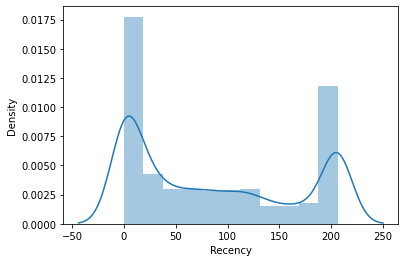

In [42]:
# simple distribution plot from seaborn library for displaying the recency values
x = rfm_scores['Recency']
ax =sns.distplot(x)

In [43]:
#Frequency, positive skewed plot
rfm_scores.Frequency.describe()

count    5000.000000
mean      162.777200
std       259.703254
min         0.000000
25%        21.000000
50%        57.000000
75%       170.000000
max      1409.000000
Name: Frequency, dtype: float64

/home/asmaosman/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



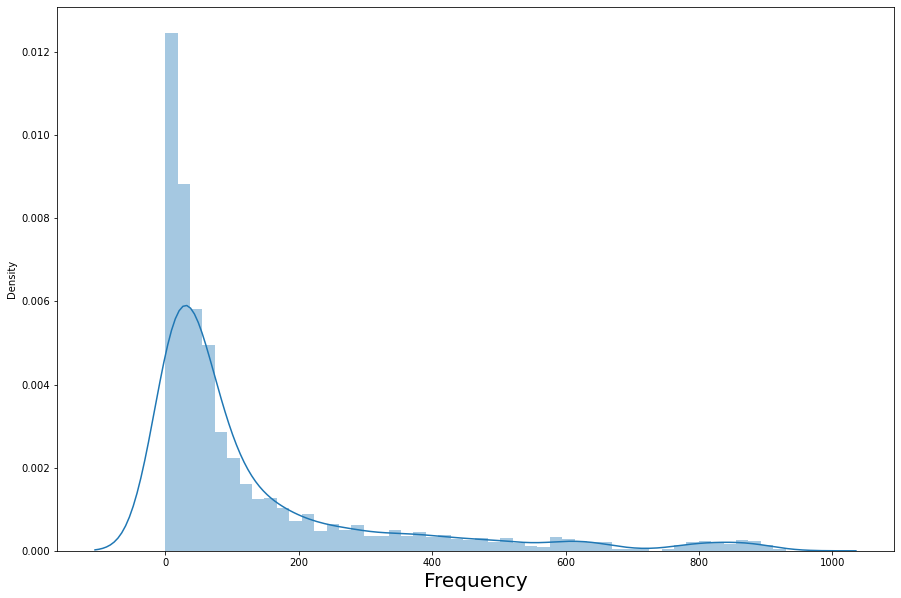

In [44]:
plt.rcParams['figure.figsize'] = (15, 10)
x = rfm_scores.query('Frequency < 1000')['Frequency']
ax = sns.distplot(x = x)
ax.set_xlabel('Frequency', fontsize = 20)
plt.show()


In [45]:
#Monetary, positive skewed plot
rfm_scores.Monetary.describe()

count     5000.000000
mean      1680.951600
std       1998.637336
min         38.000000
25%        315.000000
50%        966.000000
75%       2492.500000
max      34847.000000
Name: Monetary, dtype: float64

/home/asmaosman/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



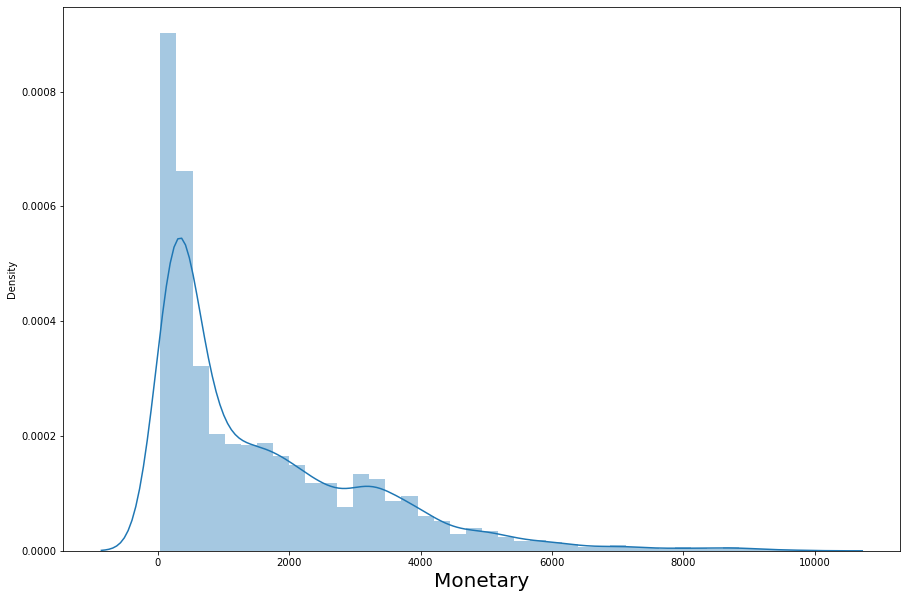

In [46]:
plt.rcParams['figure.figsize'] = (15, 10)
x = rfm_scores.query('Monetary < 10000')['Monetary']
ax = sns.distplot(x = x)
ax.set_xlabel('Monetary', fontsize = 20)
plt.show()


In [47]:
# split the values to the 4 quartiles, groups
#0-25%, 25-50%, 50-75%, 75-100%

quantiles = rfm_scores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles


{'Recency': {0.25: 6.0, 0.5: 67.0, 0.75: 170.25},
 'Frequency': {0.25: 21.0, 0.5: 57.0, 0.75: 170.0},
 'Monetary': {0.25: 315.0, 0.5: 966.0, 0.75: 2492.5}}

In [48]:
#Define low RFM function to calculate the score 
#give scores to each group, range from 1 to 5 

#Assign low scores to low recency values 
def rec_scoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.5]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

#assign scores to frequency and monetary

def fm_scoring (x,p,d):
    if x <=d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif d[p][0.75]:
        return 2
    else:
        return 1 

In [55]:
#Apply the function above on the arguments, rfm values and quantiles
 
rfm_scores['R']= rfm_scores['Recency'].apply(rec_scoring, args = ('Recency', quantiles))
rfm_scores['F']= rfm_scores['Frequency'].apply(fm_scoring, args = ('Frequency', quantiles))
rfm_scores['M']= rfm_scores['Monetary'].apply(fm_scoring, args = ('Monetary', quantiles))
rfm_scores.tail()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
251041,53,1216,59,2,2,4
251042,118,1194,59,3,2,4
261374,127,1256,51,3,2,4
268356,131,1202,45,3,2,4
279492,56,824,38,2,2,4


In [85]:
new_rfm_scores = rfm_scores.drop(['RFM_score', 'RFM_concat'],axis=1)

In [87]:
#calculate the total RFM score 
#concatenate the scores to group the scores
#add the scores to find the sum value, that is RFM score

new_rfm_scores['rfm_concat'] = new_rfm_scores.R.map(str)+rfm_scores.F.map(str)+rfm_scores.M.map(str)

new_rfm_scores ['rfm_score'] = new_rfm_scores[['R','F','M']].sum(axis=1)

new_rfm_scores.head()

,Recency,Frequency,Monetary,R,F,M,rfm_concat,rfm_score,Loyalty_ranking
CustomerID,,,,,,,,,
2333,52,8,34847,2,4,2,242,8,Gold
2334,93,15,32486,3,4,2,342,9,Gold
2335,52,24,24178,2,3,2,232,7,Silver
2336,4,21,18554,1,4,2,142,7,Silver
2337,129,76,16884,3,2,2,322,7,Silver


In [105]:
#visualize the distribution of the rfm scores
#assign names to each group according to the sum rfm score

def group_name(value):
    if(value >=10):
        return 'Diamond'
    elif (value>=8):
        return 'Gold'
    elif (value>=6):
        return 'Silver'
    else: 
        return 'Bronze'
    
#save the rankings in a list
ranking= new_rfm_scores['rfm_score'].apply(group_name)
ranking

CustomerID
2333        Gold
2334        Gold
2335      Silver
2336      Silver
2337      Silver
           ...  
251041      Gold
251042      Gold
261374      Gold
268356      Gold
279492      Gold
Name: rfm_score, Length: 5000, dtype: object

In [106]:
#Append the ranking list to the model dataframe
new_rfm_scores['Loyalty_ranking']=ranking
new_rfm_scores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,rfm_concat,rfm_score,Loyalty_ranking
0,2333,52,8,34847,2,4,2,242,8,Gold
1,2334,93,15,32486,3,4,2,342,9,Gold
2,2335,52,24,24178,2,3,2,232,7,Silver
3,2336,4,21,18554,1,4,2,142,7,Silver
4,2337,129,76,16884,3,2,2,322,7,Silver


In [108]:
#find the minimum rfm score 
new_rfm_scores['rfm_score'].min()

5

/home/asmaosman/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



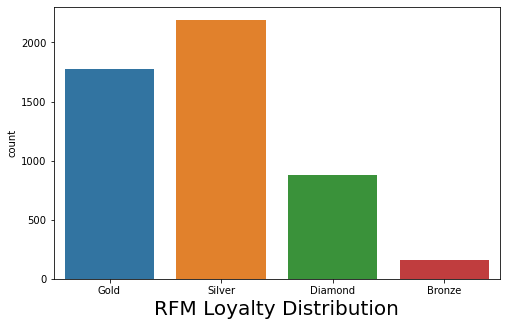

In [109]:
#visualize the distribution of the loyalty rankings 
#basic bar plot
plt.rcParams['figure.figsize'] = (8, 5)
ax = sns.countplot(new_rfm_scores['Loyalty_ranking'])
ax.set_xlabel('RFM Loyalty Distribution', fontsize = 20)
plt.show()


/home/asmaosman/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



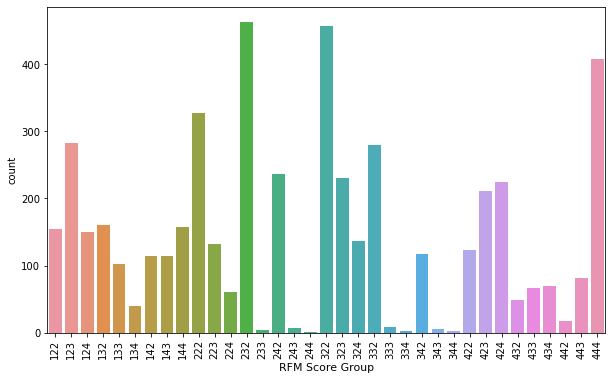

In [110]:
#visualize the distribution of the concatenated scores groups 
df2=new_rfm_scores['rfm_concat'].sort_values(ascending=True)
plt.rcParams['figure.figsize'] = (10, 6)
ax = sns.countplot(df2)
ax.set_xlabel('RFM Score Group', fontsize = 11)
plt.xticks(rotation=90)
plt.show()



In [149]:
new_rfm_scores['Loyalty_ranking'].value_counts()

Silver     2190
Gold       1775
Diamond     880
Bronze      155
Name: Loyalty_ranking, dtype: int64